In [17]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, HuberRegressor, ElasticNet, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [18]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_sentimentanalysis.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_sentimentanalysistest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 2].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 2].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,7.452470,0.000129,0.000000,1.484572e+04,0.006211,7.686411e+02,690.618472,1.0,7.0,0.427801,12.0,76.330988,5.045532e+10,10.168922
1,6.314931,0.056578,903.680000,7.635895e+06,0.006211,4.423151e+06,44196.825694,1.0,42.0,0.441701,12.0,76.330988,5.045532e+10,10.168922
2,9.499113,0.073244,1001.244444,9.543407e+06,0.006211,4.011359e+06,41064.000000,1.0,76.0,0.429230,12.0,13.216667,5.045532e+10,10.329697
3,6.085528,0.073156,1001.244444,9.533212e+06,0.026095,4.012145e+06,42053.311111,1.0,112.0,0.421655,12.0,13.216667,5.045532e+10,10.329697
4,9.452724,0.021956,182.044444,2.628813e+06,0.119376,3.909378e+03,3469.288889,1.0,140.0,0.439443,12.0,14.213889,5.045532e+10,10.159327


In [19]:
# remove 2xlarge
df = df.drop(df[df.totalcpu > 16].index)

In [20]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [21]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*0.67))/100                    
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
#df_t['replica'] = df['replica']
df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*0.67))/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
#df_ttest['replica'] = df_test['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests
0,6.137011,513.076211,0.427801,7.0
1,6.137011,513.076211,0.441701,42.0
2,1.062620,521.188136,0.429230,76.0
3,1.062620,521.188136,0.421655,112.0
4,1.142797,512.592066,0.439443,140.0


In [22]:
x_train = df_t[[col for col in df_t.columns if col != 'requests']]
y_train = df_t['requests']
x_train = preprocessing.normalize(x_train, norm='l2')
x_test = df_ttest[[col for col in df_ttest.columns if col != 'requests']]
y_test = df_ttest['requests']
x_test = preprocessing.normalize(x_test, norm='l2')

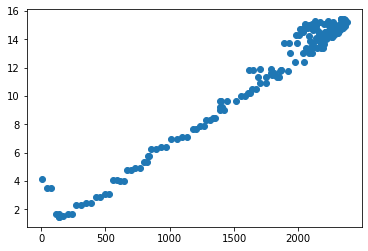

In [23]:
plt.scatter(df_ttest['requests'], df_ttest['total_cpu_util'] )

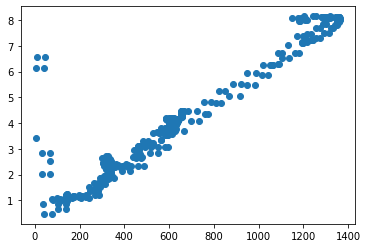

In [24]:
plt.scatter(df_t['requests'], df_t['total_cpu_util'] )

## Linear Regression

Training Score  0.869067829491147
Testing Score  0.8740725647647568


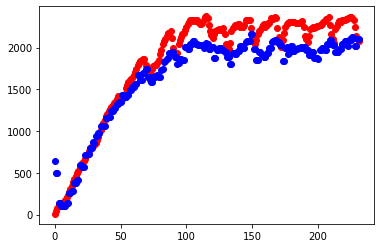

In [25]:
parameters = {'fit_intercept': [True,False],
             'copy_X': [True,False]}
#linear = GridSearchCV(LinearRegression(),
#                      parameters, 
#                      cv=7,
#                      scoring='r2',
#                      n_jobs=-1)
linear = LinearRegression(fit_intercept=False)
linear.fit(x_train, y_train)

y_tr_pred = linear.predict(x_train)
y_te_pred = linear.predict(x_test)

#print('linear reg score on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
#print('linear reg score on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

print("Training Score ",linear.score(x_train,y_train))
print("Testing Score ",linear.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', linear.best_score_)
#print('Best Params: ', linear.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

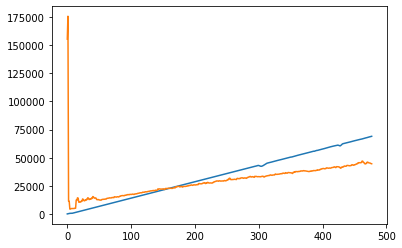

In [10]:
plt.plot(y_test)
plt.plot(y_te_pred)

## Polynomial Regression

Training Score  0.8730608188102329
Testing Score  0.9578071144637769
Best Params:  {'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 4}


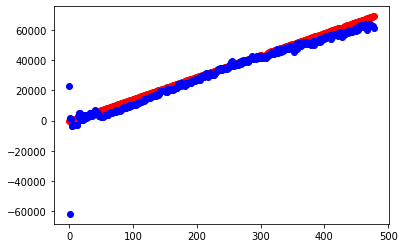

In [11]:
def PolynomialRegression(**kwargs):
    return make_pipeline(PolynomialFeatures(), LinearRegression(**kwargs))
degrees = [2, 3,4 ]
param_grid = {'polynomialfeatures__degree': degrees, 'linearregression__fit_intercept': [False]}
polynomial = GridSearchCV(PolynomialRegression(),
                      param_grid, 
                      cv=5,
                      scoring='r2',
                      n_jobs=-1)
polynomial.fit(x_train, y_train)

y_tr_pred = polynomial.predict(x_train)
y_te_pred = polynomial.predict(x_test)

#print('linear reg score on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
#print('linear reg score on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

print("Training Score ",polynomial.score(x_train,y_train))
print("Testing Score ",polynomial.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', polynomial.best_score_)
print('Best Params: ', polynomial.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

## Ridge Regression

Training Score  0.8832241529183663
Testing Score  0.8449576154288188
Best Params:  {'alpha': 1e-20, 'fit_intercept': True, 'max_iter': 10, 'solver': 'auto'}


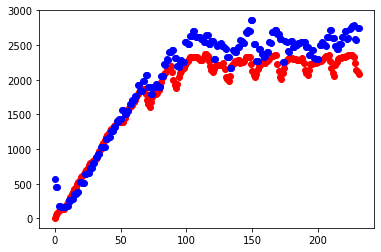

In [28]:
alphas = np.logspace(-20,10,num=20)
param_grid = {'max_iter': np.arange(10,100,10),
             'alpha': alphas,
            'solver': ['auto', 'svd'],
             'fit_intercept':[True, False]}
ridge_cv = GridSearchCV(Ridge(),
                       param_grid=param_grid,
                         cv=3, 
                         scoring='r2',
                         n_jobs=-1)

ridge_cv.fit(x_train, y_train)

y_tr_pred = ridge_cv.predict(x_train)
y_te_pred = ridge_cv.predict(x_test)

print("Training Score ",ridge_cv.score(x_train,y_train))
print("Testing Score ",ridge_cv.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', ridge_cv.best_score_)
print('Best Params: ', ridge_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

## Lasso Regression

In [13]:
alphas = np.logspace(-20,10,num=20)

param_grid = {'max_iter': np.arange(10,100,10),
             'alpha': alphas,
             'fit_intercept':[True, False],
             'selection': ['cyclic', 'random'],
             'positive':[True, False],
             'warm_start':[True, False],
             'copy_X':[True, False]}

lasso_cv = GridSearchCV(Lasso(),
                       param_grid=param_grid,
                         cv=3, 
                        scoring='r2',
                         n_jobs=-1,
                       verbose=1)

lasso_cv.fit(x_train, y_train)

y_tr_pred = lasso_cv.predict(x_train)
y_te_pred = lasso_cv.predict(x_test)

print("Training Score ",lasso_cv.score(x_train,y_train))
print("Testing Score ",lasso_cv.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', lasso_cv.best_score_)
print('Best Params: ', lasso_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

Fitting 3 folds for each of 5760 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1334 tasks      | elapsed:  2.0min
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.6/site-packages/joblib/parallel.py", line 921, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/ubuntu/.local/lib/python3.6/site-packages/joblib/_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "/usr/lib/python3.6/concurrent/futures/_base.py", line 427, in result
    self._condition.wait(timeout)
  File "/usr/lib/python3.6/threading.py", line 295, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py", line 736, in fit
    self._run_search(evaluate_candidates)
  File "/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py", line 1188, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "

TypeError: object of type 'NoneType' has no len()

## Huber Regressor

In [ ]:
epsilon = np.arange(1, 1.5, 0.05)

param_grid = {'max_iter': np.arange(10,100,10),
             'alpha': alphas,
              'epsilon': epsilon,
             'fit_intercept':[True, False],
             'warm_start':[True, False]}

huber_cv = GridSearchCV(HuberRegressor(),
                       param_grid=param_grid,
                         cv=3, 
                         scoring='r2',
                         n_jobs=-1,
                       verbose=1)

huber_cv.fit(x_train, y_train)

y_tr_pred = huber_cv.predict(x_train)
y_te_pred = huber_cv.predict(x_test)

print("Training Score ",huber_cv.score(x_train,y_train))
print("Testing Score ",huber_cv.score(x_test,y_test))



#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', huber_cv.best_score_)
print('Best Params: ', huber_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

## Random Forrest Regressor

Training Score  0.9359041676854883
Testing Score  -0.6191525356897833
Best Params:  {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 6, 'n_estimators': 100}


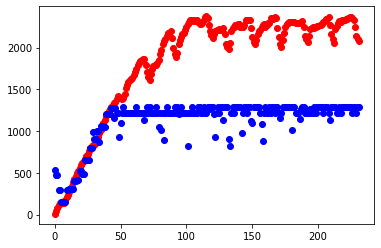

In [26]:
parameters = {  
                 'min_samples_leaf': [2, 4, 6],
                 'max_depth': np.arange(1,6,1),
                 'n_estimators': [100],
                'max_features': ['auto']
}

rf_cv = GridSearchCV( RandomForestRegressor(),
                      param_grid=parameters, 
                      cv=3, 
                      scoring='r2',
                      n_jobs=-1)

rf_cv.fit(x_train, y_train)

y_tr_pred = rf_cv.predict(x_train)
y_te_pred = rf_cv.predict(x_test)


print("Training Score ",rf_cv.score(x_train,y_train))
print("Testing Score ",rf_cv.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', rf_cv.best_score_)
print('Best Params: ', rf_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

Test R² : -0.5724611239509769
Train R² : 0.9371321016633877


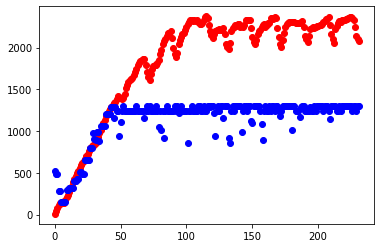

In [27]:
finalrf_cv = RandomForestRegressor(max_depth=20, min_samples_leaf=6, n_estimators=150)
finalrf_cv.fit(x_train, y_train)
y_tr_pred = finalrf_cv.predict(x_train)
y_te_pred = finalrf_cv.predict(x_test)

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('Test R² :',R)

R = r2_score(y_train, y_tr_pred)
print ('Train R² :',R)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

## ElasticNet

Training Score  0.7276158510599164
Testing Score  0.8186236216079554
Best Params:  {'alpha': 7.847599703514623e-13, 'l1_ratio': 0.6}


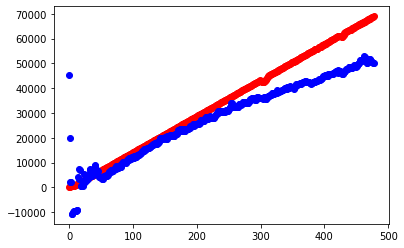

In [16]:
# find optimal alpha with grid search
alpha = np.logspace(-20,10,num=20)
l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
param_grid = dict(alpha=alpha, l1_ratio=l1_ratio)
grid = GridSearchCV(ElasticNet(), 
                    param_grid=param_grid,
                    cv=7,
                    scoring='r2', 
                    n_jobs=-1)

grid_result = grid.fit(x_train, y_train)

y_tr_pred = grid.predict(x_train)
y_te_pred = grid.predict(x_test)

print("Training Score ",grid_result.score(x_train,y_train))
print("Testing Score ",grid_result.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

## Gradient Boosting Regressor

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 40.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 84.8min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 115.2min finished


Training Score  -9297.66410365468
Testing Score  -44287.40797517014
Best Params:  {'learning_rate': 0.02, 'loss': 'lad', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 1000}


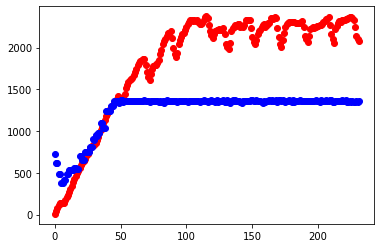

In [29]:
learning_rate = np.arange(0,0.2,0.001)
parameters = {  
                 'learning_rate': [0.02],
                 'min_samples_split': [10, 15, 20],
                 'min_samples_leaf': [10, 15, 20],
                 'max_depth': [3, 4, 5],
                 'n_estimators': [1000, 1500, 2000],
                 'loss': ['ls', 'lad', 'huber', 'quantile'],
                 'max_features': ['sqrt']
             }


GBoost_cv = GridSearchCV(GradientBoostingRegressor(), 
                         param_grid=parameters, 
                         n_jobs=-1, 
                         scoring='r2',
                         cv=5,
                        verbose=1)
#GBoost_cv = GradientBoostingRegressor(learning_rate=0.02)

GBoost_cv.fit(x_train, y_train)

y_tr_pred = GBoost_cv.predict(x_train)
y_te_pred = GBoost_cv.predict(x_test)

print("Training Score ",grid_result.score(x_train,y_train))
print("Testing Score ",grid_result.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', GBoost_cv.best_score_)
print('Best Params: ', GBoost_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')